In [3]:
import numpy as np

In [57]:
class DataNode():
    def __init__(self, activity_patterns):
        self.n_neurons=activity_patterns.shape[0]
        self.activity_patterns=activity_patterns
        
class SimuNode():
    def __init__(self,n_neurons):
        self.n_neurons=n_neurons
        
class Synapse():
    def __init__(self,pre_synaptic_node, post_synaptic_node,syn_type='exc',plasticity=None):
        self.pre_synaptic_node=pre_synaptic_node
        self.post_synaptic_node=post_synaptic_node
        self.syn_type=syn_type
        if plasticity=='BCM':
            self.theta_BCM = 0
            self.theta_BCM_dt = .001
            self.BCM_target = 5000.0
            self.alpha = 0.01
        
    def connect(self):
        row_dim=self.pre_synaptic_node.n_neurons
        col_dim=self.post_synaptic_node.n_neurons
        k=7.5
        theta=1.0
        if self.syn_type=='inh':
            self.syn_weights=-np.random.gamma(shape=k,scale=theta,size=(col_dim,row_dim))
            #self.syn_weights=-np.random.normal(loc=0,size=(col_dim,row_dim))
        elif self.syn_type=='exc':
            self.syn_weights=np.random.gamma(shape=k,scale=theta,size=(col_dim,row_dim))
            
    def learn(self,pre_syn_activities,post_syn_activities):
        if plasticity=='BCM':
            self._update_weights_BCM(pre_syn_activities,post_syn_activities)
            self._update_BCM_threshold(post_syn_activities)
        
    def _update_weights_BCM(self,pre_syn_activities,post_syn_activities):
        print('W before',self.syn_weights.shape)
        #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
        self.syn_weights+= self.alpha*pre_syn_activities@post_syn_activities@(post_syn_activity_pattern-self.theta_BCM)
        print('W after',self.syn_weights.shape)
        
    def _update_BCM_threshold(self,activity_pattern):
        self.theta_BCM += self.theta_BCM_dt*((activity_pattern/self.BCM_target)*activity_pattern - self.theta_BCM)
        
class Simulate():
    def __init__(self,init_dict,data):
        self.init_dict=init_dict
        self.connectivity_graph=self.init_dict['connectivity_graph']
        self.node_classification=self.init_dict['node_classification']
        self.node_ns=self.init_dict['node_ns']
        self.data=data
        self.data_dict={}
        self.sim_dict={}
        dat_ind=0
        #exc_dat_ind=0
        sim_ind=0
        #exc_sim_ind=0
        self.prev_timepoint=[]
        self.act_lst=[]
        for j in range(len(self.node_classification)):
            if self.node_classification[j]=='data_inh':
                self.data_dict[j]=dat_ind
                dat_ind+=1
            if self.node_classification[j]=='data_exc':
                self.data_dict[j]=dat_ind
                dat_ind+=1
            if self.node_classification[j]=='simulated_exc':
                self.sim_dict[j]=sim_ind
                self.prev_timepoint.append(np.zeros(self.node_ns[j],))
                self.act_lst.append([])
                sim_ind+=1
            if self.node_classification[j]=='simulated_inh':
                self.sim_dict[j]=sim_ind
                self.prev_timepoint.append(np.zeros(self.node_ns[j],))
                self.act_lst.append([])
                sim_ind+=1
        
    def _connect(self):
        node_lst=[]
        for node_ind,node in enumerate(self.node_classification):
            print(node)
            if node=='simulated_inh':
                node_lst.append(SimuNode(self.node_ns[node_ind]))
            if node=='simulated_exc':
                node_lst.append(SimuNode(self.node_ns[node_ind]))
            if node=='data_inh':
                ind=self.data_dict[node_ind]
                node_lst.append(DataNode(self.data[ind]))
            if node=='data_exc':
                ind=self.data_dict[node_ind]
                node_lst.append(DataNode(self.data[ind]))
        self.syn_dict_pre={}
        self.syn_dict_post={}
        i=0
        self.syn_lst=[]
        for pre in range(0,self.connectivity_graph.shape[0]):
            for post in range(0,self.connectivity_graph.shape[1]):
                if self.connectivity_graph[pre,post]==1:
                    if node_classification[pre][-3:]=='exc':
                        syn_type='exc'
                    elif node_classification[pre][-3:]=='inh':
                        syn_type='inh'
                    #Synapses cannot exist between data nodes, ensure that!
                    syn=Synapse(node_lst[pre],node_lst[post],syn_type)
                    syn.connect()
                    self.syn_dict_pre[i]=pre
                    self.syn_dict_post[i]=post
                    self.syn_lst.append(syn)
                    i+=1
        
    def one_step(self,t):
        self._connect()
        sim_one_t=[]
        nodes_to_update=[]
        self.nodes_dims=[]
        for i,node in enumerate(self.node_classification):
            if node[:3]=='sim':
                nodes_to_update.append(i)
                self.nodes_dims.append(self.node_ns[i])
        for i,node in enumerate(nodes_to_update):
            inds=self.connectivity_graph[:,i].flatten()
            weights_stack=np.zeros((self.nodes_dims[i],1))
            act_stack=np.zeros((1,))
            for syn_ind,syn in enumerate(self.syn_lst):
                if self.syn_dict_post[syn_ind]==node:
                    pre_ind=self.syn_dict_pre[syn_ind]
                    weights_stack=np.hstack((weights_stack,syn.syn_weights))
                    act_stack=np.hstack((act_stack,data[pre_ind][:,t].flatten()))
            weights_stack=weights_stack[:,1:]
            act_stack=act_stack[1:]
            activation=-self.prev_timepoint[i]+weights_stack@self.transfer_function(act_stack)
            self.prev_timepoint[i]=activation
            self.act_lst[i].append(activation)

    def simulate(self):
        for t in range(0,100):
            self.one_step(t)
        print(self.act_lst)
        merged_lst=[]
        for j in range(0,len(self.act_lst)):
            act=np.array(self.act_lst[j]).reshape(self.nodes_dims[j],-1)
            merged_lst.append(act)
        return merged_lst
            
    def transfer_function(self,x):
        r_0 = 1.0
        r_max = 100.0
        x[x<0]=0
        x[x>=0]=(r_max-r_0)*np.tanh(x[x>=0]/(r_max-r_0))
        return x
        
            
        
        

In [58]:
node_classification=['data_exc','data_inh','simulated_exc']
connectivity_graph=np.array([[0,0,1],[0,0,1],[0,0,0]])
node_ns=[exc_dat.shape[0],inh_dat.shape[0],4]
data=[exc_dat,inh_dat]

init_dict={'node_classification':node_classification,'connectivity_graph':connectivity_graph,'node_ns':node_ns}
activities=Simulate(init_dict,data).simulate()


data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc
data_inh
simulated_exc
data_exc

[[ 123782.89658688  126540.33237296  127034.32459714  126087.61753777
    -1473.38699408   -5310.25305687    -187.44435081   -4250.03085596
   119086.93116546  123709.69216988  111722.55782974  118731.94040499
   -50653.79251533  -64155.98055541  -50830.81938079  -56061.98190786
   125368.41747022  137911.27704345  125438.80436084  131066.27557997
   -22835.10974194  -27663.46903477  -12513.00781362  -16665.93117122
   126003.53333958  125579.26982922  111883.70021352  116902.37940257
   -52664.18882564  -50689.11764793  -36457.58922782  -46657.17982178
   113611.10167604  111704.20660633   96927.11191593  105336.5871498
   -46210.19016069  -37604.62878981  -26233.56506066  -38312.51890235
   116560.32432372  101707.19973011   90308.67908114  103382.64774344
   -76033.58095709  -59951.0986791   -50791.90037728  -60708.39481046
   142273.16908166  121649.63338546  113292.18218225  126964.42534919
   -75388.70699581  -55343.84468557  -49747.04962975  -58451.43192755
   109762.49111289   

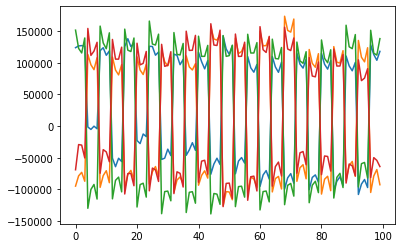

In [59]:
print(activities[0])
import matplotlib.pyplot as plt
plt.plot(activities[0].T)

In [6]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
#U=np.load('U.npy')

Shape of the data matrix, neurons by timepoints: (18795, 30766)


In [7]:
U=np.load('U.npy')

In [9]:
#del spks
del S

In [8]:
stim_ens_inds=np.nonzero(U[:,13])[0]
exc_dat=S[stim_ens_inds]
inh_dat=S[np.random.randint(0,S.shape[0],size=100),:]

In [12]:
print(exc_dat.shape)

(642, 30560)


In [9]:
inh_dat=S[np.random.randint(0,S.shape[0],size=10),:]
exc_dat=S[np.random.randint(0,S.shape[0],size=100),:]

In [7]:
np.random.randint(0,100,size=100)

array([63, 86, 49,  1, 55, 81,  2, 97, 27, 53, 32, 11, 35, 41, 51, 93, 31,
       52, 28, 89, 70, 17, 46, 85, 37, 49, 70, 78, 57, 91, 47, 70, 50, 60,
       87, 81, 76, 39,  3, 62, 64, 70,  2, 72, 73, 72, 71, 89,  5, 73, 53,
       47,  8,  6, 33, 33, 23, 79, 30, 72, 60, 43, 84, 58, 20, 13, 93, 48,
       71, 90, 29, 88, 77, 26, 48, 82, 65, 51, 60, 22,  0, 96,  1, 53, 21,
       58, 34, 58, 59, 24, 31, 11, 20, 25, 43, 12, 11, 76, 93, 38])